In [1]:
import logging; logging.basicConfig(level=logging.DEBUG)
import time

import mr_box_peripheral_board as mrbox
import serial
reload(mrbox)

# Try to connect to MR-Box control board.
retry_count = 2
for i in xrange(retry_count):
    try:
        proxy.close()
    except NameError:
        pass
    try:
        proxy = mrbox.SerialProxy(baudrate=57600)
        break
    except serial.SerialException:
        time.sleep(1)
else:
    raise IOError('Could not connect to MR-Box control board.')
    
proxy._timeout_s = 20

DEBUG:base_node_rpc.proxy:Connection unsuccessful on port COM10 after 1 attempts.
DEBUG:base_node_rpc.proxy:Connection unsuccessful on port COM10 after 2 attempts.
DEBUG:base_node_rpc.proxy:Connection unsuccessful on port COM10 after 3 attempts.
DEBUG:base_node_rpc.proxy:Connection unsuccessful on port COM10 after 4 attempts.
INFO:base_node_rpc.proxy:Successfully connected to mr-box-peripheral-board on port COM10


# PMT

In [2]:
import si_prefix as si

from mr_box_peripheral_board import pmt_ui
reload(pmt_ui)

pmt_ui_ = pmt_ui.PmtUI(proxy)
pmt_ui_.widget

# MAX11210 ADC

In [9]:
from mr_box_peripheral_board import max11210_adc_ui
reload(max11210_adc_ui)

# max11210_adc_ui_ = max11210_adc_ui.Max11210AdcUI(proxy)
# max11210_adc_ui_.widget

import ipywidgets as ipw

In [10]:
INPUT_RANGE_UNIPOLAR = 1
INPUT_RANGE_BIPOLAR = 2
CLOCK_SOURCE_EXTERNAL = 1
CLOCK_SOURCE_INTERNAL = 2
FORMAT_OFFSET = 1
FORMAT_TWOS_COMPLEMENT = 2
CONVERSION_MODE_SINGLE = 1
CONVERSION_MODE_CONTINUOUS = 2


def MAX11210_begin(proxy):
    proxy.MAX11210_setDefault();
    proxy.MAX11210_setLineFreq(60);  # 60 Hz
    proxy.MAX11210_setInputRange(INPUT_RANGE_UNIPOLAR);
    proxy.MAX11210_setClockSource(CLOCK_SOURCE_INTERNAL);
    proxy.MAX11210_setEnableRefBuf(True);
    proxy.MAX11210_setEnableSigBuf(True);
    proxy.MAX11210_setFormat(FORMAT_OFFSET);
    proxy.MAX11210_setConvMode(CONVERSION_MODE_SINGLE);
    proxy.MAX11210_selfCal();
    proxy.MAX11210_sysOffsetCal();
    proxy.MAX11210_sysGainCal();

In [11]:
from collections import OrderedDict
import pandas as pd

MAX11210_begin(proxy)
calibration_settings = \
    pd.Series(OrderedDict([('SelfCalGain', proxy.MAX11210_getSelfCalGain()),
                           ('SelfCalOffset', proxy.MAX11210_getSelfCalOffset()),
                           ('SysGainCal', proxy.MAX11210_getSysGainCal()),
                           ('SysOffsetCal', proxy.MAX11210_getSysOffsetCal())]))
print '# Calibration settings #\n'
print calibration_settings

# Calibration settings #

SelfCalGain      12572691
SelfCalOffset          54
SysGainCal       16777215
SysOffsetCal        99628
dtype: int64


In [12]:
print '# Register statuses #\n'
print '----- STAT1 -----\n' + max11210_adc_ui.format_STAT1(proxy.MAX11210_getSTAT1()) + '\n'
print '----- CTRL1 -----\n' + max11210_adc_ui.format_CTRL1(proxy.MAX11210_getCTRL1()) + '\n'
# print '----- CTRL2 -----\n' + str(format(proxy.MAX11210_getCTRL2(),'b')) + '\n'
print '----- CTRL3 -----\n' + max11210_adc_ui.format_CTRL3(proxy.MAX11210_getCTRL3())

# Register statuses #

----- STAT1 -----
Gain Over Range: True
Sampling Rate: 1 Sample/sec
Input Signal Over Max: False
Input Signal Under Min: False
Modulator Status: Idle
ADC Status: In Progress


----- CTRL1 -----
Line frequency: 60Hz
Input Range: Unipolar (Positive Only)
Clock: Internal
Refference Buffer: On
Signal Buffer: On
Format: Offset
Cycle: Single


----- CTRL3 -----
Digital Gain: X1
System Gain: Enabled
System Offset: Enabled
Self-calibration Gain: Enabled
Self-calibration Offset: Enabled



Sampling Rate: 1 Hz
Digital Gain: 1


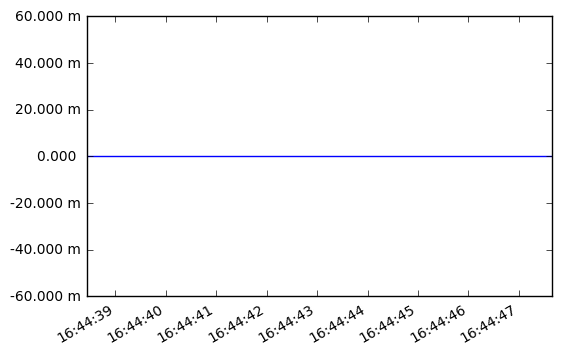

In [13]:
%matplotlib inline
import datetime as dt

import matplotlib as mpl
import matplotlib.ticker
import si_prefix as si
from IPython.display import display


formatter = mpl.ticker.FuncFormatter(lambda x, *args: si.si_format(x, 3))

Vref = 3.0 #Reference Voltage 3.0 V

def _pmt_read(*args):
    
#     proxy.MAX11210_setConvMode(CONVERSION_MODE_SINGLE)
    proxy.MAX11210_setGain(adc_gain.value)
    raw_values = max11210_adc_ui.MAX11210_read(proxy, pmt_rate.value, pmt_duration.value)
    print 'Sampling Rate: ' + str(pmt_rate.value) + ' Hz'
    print 'Digital Gain: ' + str(adc_gain.value)
    voltage = (raw_values / (2 ** 24 - 1))*(Vref/adc_gain.value)
    current = voltage / 30e3  # 30 kOhm
    
    current.to_clipboard()
    
    axis = current.plot()
    axis.yaxis.set_major_formatter(formatter)

    
pmt_rate = ipw.Dropdown(description='Sample rate (Hz)',
                        options=(1, 2, 5, 10, 15, 30, 60, 120), value=1)
adc_gain = ipw.Dropdown(description='Digital Gain',
                        options=(OrderedDict([('X1',1),('X2',2),('X4',4),('X8',8),('X16',16)])), value=1)
pmt_duration = ipw.FloatSlider(description='PMT duration (s)', min=1,
                               max=1000, value=10)

pmt_read = ipw.Button(description='Read PMT')
pmt_read.on_click(_pmt_read)

ipw.VBox([pmt_rate,adc_gain, pmt_duration, pmt_read])